In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("data/raw_data.csv", index_col=0)

# Initial cleaning of dataframe

### Create a target column & remove 'leaky' columns from training data
We are using past data to train a model to predict cases of fraud among future data. The original dataset includes columns with information that will not be available for future data. These columns need to be excluded from analysis to eliminate information leakage.

But first, we need to use the information in the 'account' column to create a target column. This will label each row as either 'fraud' or 'not fraud'. The original 'account' column contains a range of values describing an account type. 

In [3]:
### Create fraud column as target.
data["fraud"] = data["account"].str.contains("fraud")
data.fraud.value_counts() 

False    13044
True      1293
Name: fraud, dtype: int64

### Common trends in fraud detection for ticket vendors:
* In our data, the number of non-fraudulent entries is about 10 times the number of frauds. This imbalance is fairly typical and is important to keep in mind when considering model results. 

* Generally speaking, it is more expensive to miss an instance of fraud than it is to mistakenly identify a non-fraudulent event. As such, we will want to assign greater importance to false negatives than false positives

In [4]:
### Drop the fields of information that will not be included for 'future' data
data.drop(['account', 'payout_date', 'xt', 'order_count', 'payout_count', 'sale_duration2'], axis=1, inplace=True)

# Understanding Features
In ideal scenarios, we have full access to all information about our data and how it was collected. Yet it is good to be prepared for the less ideal situations. Whether due to poor records, employee turnover, time constraints, etc., sometimes there will be gaps in information. 

In this instance, the only information available is in the data, as column names and values. 

## 1. Quick look at the data
The column names aren't always clear descriptors, so it helps to look at a few rows of data. 

*Note: to preserve anonymity for both the ticket vendor and clients, I'll exclude columns with identifiable information from view. Because this limits your ability to understand the data in these columns, I've included a table with fictional entries to demonstrate the values contained in the omitted columns.*

In [5]:
exclude_cols = ['description', 'email_domain', 'name', 'org_desc', 'org_name', 'payee_name', 'past_payouts',
'venue_address', 'venue_name', 'venue_latitude', 'venue_longitude']

preview = data.copy()
preview.drop(exclude_cols, axis=1, inplace=True)

In [6]:
preview.iloc[:5,:13]

,body_length,channels,country,currency,delivery_method,date_created,end_date,date_published,start_date,fb_published,analytics,header,logo
0,3852,5,US,USD,0.0,1262739706,1265630400,1.263110e+09,1265594400,0,0,1.0,0
1,3499,0,US,USD,1.0,1293832670,1296288000,1.293833e+09,1296255600,0,0,0.0,1
2,2601,8,US,USD,1.0,1291090956,1295740800,1.291092e+09,1295713800,0,0,NaN,0
3,12347,6,IE,EUR,1.0,1360681570,1388534400,1.360683e+09,1360702800,0,0,0.0,1
4,2417,11,US,USD,0.0,1291994666,1297468800,1.291995e+09,1297440000,1,0,0.0,0


In [7]:
preview.iloc[:5,13:23]

,listed,name_length,object_id,org_facebook,org_twitter,payout_method,sale_duration,map,ticket_groups,user_age
0,y,60,527017,0.0,0.0,NaN,29.0,1,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36
1,n,27,786878,0.0,12.0,CHECK,28.0,0,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149
2,y,28,787337,0.0,0.0,CHECK,54.0,0,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214
3,y,21,885645,0.0,0.0,ACH,0.0,0,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889
4,y,66,1114349,0.0,0.0,CHECK,63.0,0,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35


In [8]:
preview.iloc[:5,23:]

,member_created,member_type,venue_country,venue_state,fraud
0,1259613950,1,US,FL,True
1,1280942776,3,US,SC,False
2,1272559388,3,US,CA,False
3,1283870102,3,NaN,NaN,False
4,1288984065,3,US,MA,False


#### To complete your quick look, here are descriptions and fictitious entries for the columns omitted above: 
| Column Name     |                Column Description                  | dtype  |   Sample Entry               |
|:---------------:|:--------------------------------------------------:|:------:|:----------------------------:|
| name            | Name of the event                                  | string | ABC's Annual Fundraiser      |
| description     | Description of the event                           | string |  `<h3><span class="subcategory"><strong> Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. </strong><strong></strong></span></h3> <h3><font face="arial,helvetica,sans-serif" size="3">W Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat..</font></h3>`  |
| email_domain    | Email domain of the event creator                  | string | Ex: gmail.com; ed.ac.uk; ABC.org |
| org_name        | Name of the organization hosting the event         | string |       ABC                    |
| org_desc        | Description of the organization hosting the event  | string | `<p>ABC is a sample organization name</p>`|
| payee_name      | Named recipient of ticket revenue                  | string | Ex: ABC; Joe Smith           |
| past_payouts    | Details of past ticket purchase to event creator   | string |`[{'name': 'ABC', 'created': '2010-10-01 01:10:09', 'country': 'OZ', 'amount': 34389.38, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-02-02 01:12:10', 'country': 'OZ', 'amount': 764.93, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-03-15 01:30:42', 'country': 'OZ', 'amount': 17405.26, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-03-15 01:30:42', 'country': 'OZ', 'amount': 2224.16, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}]`|
| venue_name      | Name of event venue                                | string |     ABC Building      |
| venue_address   | Address of event venue                             | string | 123 Yellow Brick Road |
| venue_latitude  | Latitude of event venue                            | float  |      -45.0123         |
| venue_longitude | Longitude of event venue                           | float  |      -123.456         |





## 2. Dive deeper into columns
* #### Split up columns by data type
* #### Get summary info about each column
* #### Basic clean up (i.e. fill NaN values for sake of plotting)
* #### Plot columns to visualize data distribution

These steps will give us a more complete picture of the information contained in each column. 

In [9]:
str_col = list(data.dtypes[data.dtypes=='object'].index)
flt_col = list(data.dtypes[data.dtypes=='float'].index)
int_col = list(data.dtypes[data.dtypes=='int'].index)

In [10]:
# Let's keep track of categorical columns we find 
cat_cols = []

We'll write a function to generate an easy-to-read summary of some useful column information

In [11]:
def report(lst):
    lst_unq = []
    lst_mode = []
    lst_max = []
    lst_min = []
    lst_na = []
    lst_ct_mode = []
    for x in lst:
        if data[x].dtype == 'object':
            lst_unq.append(data[x].nunique())
            lst_na.append(data[x].isna().sum())
        else:
            lst_unq.append(data[x].nunique())
            lst_max.append(data[x].max()) 
            lst_min.append(data[x].min())
            lst_na.append(data[x].isna().sum())
            md = data[x].mode().values[0]
            lst_mode.append(md)
            lst_ct_mode.append(f'{round(data[x].value_counts().values[0]/len(data)*100, 2)}%')
    report = pd.DataFrame([lst, lst_unq, lst_na, lst_max, lst_min, lst_mode, lst_ct_mode], index=['name', 'Number of Unique Values', 'Number of NaN', 'Max', 'Min', 'Mode', 'Frequency of Mode'])
    return report

## 2.1 Integer Columns

In [12]:
report(int_col).T

,name,Number of Unique Values,Number of NaN,Max,Min,Mode,Frequency of Mode
0,body_length,6595,0,65535,0,0,5.78%
1,channels,11,0,13,0,8,23.46%
2,date_created,14335,0,1382011776,1170332468,1365541045,0.01%
3,end_date,9655,0,1523055600,1170824400,1357034400,0.2%
4,start_date,9274,0,1418850000,1170819000,1357012800,0.27%
5,fb_published,2,0,1,0,0,87.26%
6,analytics,2,0,1,0,0,92.7%
7,logo,2,0,1,0,1,84.21%
8,name_length,185,0,254,0,36,2.29%
9,object_id,14337,0,8792893,47146,47146,0.01%


#### We can use the summary information to determine what type of plot will best help us visualize the distribution of values in each column.  
* **date_created, end_date, start_date, member_created :** In these four columns, we can see that both the minimum and maximum values have 10 digits. Combined with the column names, we can speculate that these columns contain Unix Timestamps. 
* **object_id :** Because the number of unique values, 14337, equals the number of rows, we can guess this column contains unique IDs assigned to each entry. 
* **body_length, name_length, user_age :**
* **fb_published, analytics, logo, map :**
* **member_type, channels :**

### A - Continuous

Here is a diagram to help interpret the upcoming boxplots: 
![Diagram to explain boxplots](images/boxplot.png "Diagram to explain boxplots")

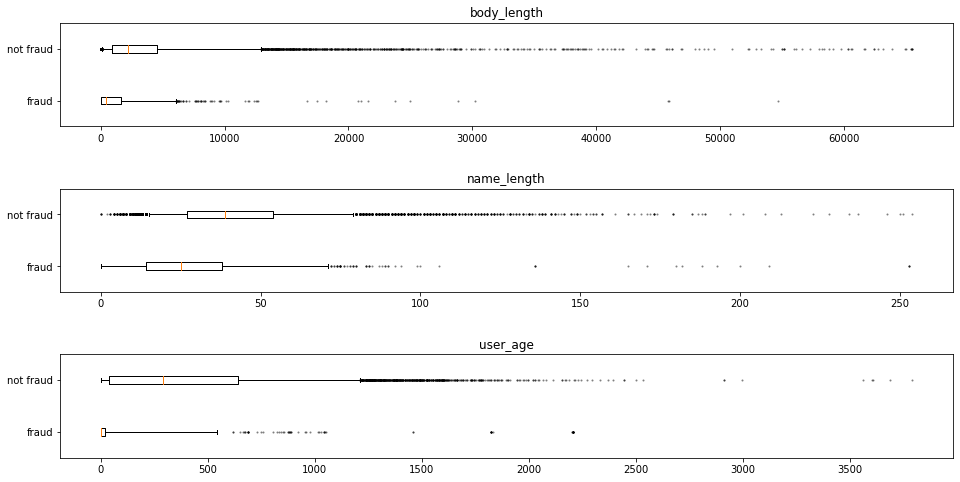

In [13]:
cont_cols = ['body_length', 'name_length', 'user_age']
fig, axs = plt.subplots(3,1, figsize =(16,8))
for idx, ax in enumerate(axs.flatten()):    
    ax.boxplot([data[data.fraud == True][cont_cols[idx]], data[data.fraud == False][cont_cols[idx]]], 
               labels=['fraud', 'not fraud'], flierprops=dict(marker='.', markersize=2, alpha=.5), vert=False,
               whis=[5, 95])
    ax.set_title(cont_cols[idx])
plt.subplots_adjust(hspace = 0.6)

### B - Categorical
* ##### fb_published

In [14]:
data.fb_published.value_counts()

0    12510
1     1827
Name: fb_published, dtype: int64

The pandas method **value_counts( )** is handy, but we still don't have all of the information we'd like to know. We are also looking for any indication of a correlation between each column and our target column, 'fraud'. Look at the rate of fraud for each possible value of the column. Is the fraud rate different between values? We'll write a function **compare_fraud_rate** to answer this question. 

We're looking to discover instances where the rate of fraud is different for different column values, as this suggests the column may contribute to identifying fraud. That said, this is just an initial exploration. We don't yet know if the differences in fraud rate are statistically significant, and determining that is outside the scope of our EDA. 

In [15]:
def compare_fraud_rate(col):
    n = len(data[col].unique())
    s = 6
    t = 100
    if n > 2:
        s += .5 * n
        t /= 2
    plt.subplots(figsize=(s,6))
    ax = sns.countplot(x=col, hue='fraud', data=data)
    for p in ax.patches:
        if np.isnan(p.get_height()): 
            height = 0
        else: 
            height = int(p.get_height())
        pos = round(p.get_x()+p.get_width()/2,2)
        ax.text(pos, height + t,f'{height}',
                ha="center") 
    ax.set_ylabel('Number of Occurences')
    ax.set_xlabel(f'Value in "{col}"')
    ax.set_title(f'Distribution of Values in Column:  "{col}"')
    plt.show()
    for f in sorted(data[col].unique()):
        pct = data[data[col] == f].fraud.value_counts(normalize=True)
        if len(pct) > 1:
            print(f'The percentage of fraud for entries with {col} equal to {f} is {round(pct[1]*100, 2)}%')
        elif pct.index==False:
            print(f'The percentage of fraud for entries with {col} equal to {f} is 0%')
        else:
            print(f'The percentage of fraud for entries with {col} equal to {f} is 100%')

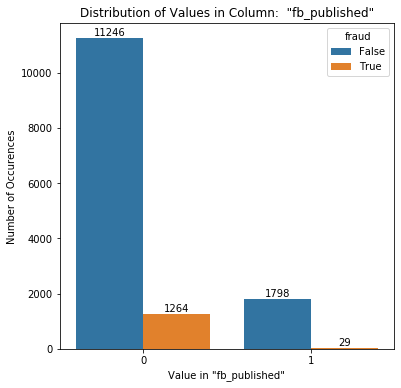

The percentage of fraud for entries with fb_published equal to 0 is 10.1%
The percentage of fraud for entries with fb_published equal to 1 is 1.59%


In [16]:
compare_fraud_rate('fb_published')

* ##### analytics

In [17]:
data.analytics.value_counts()

0    13290
1     1047
Name: analytics, dtype: int64

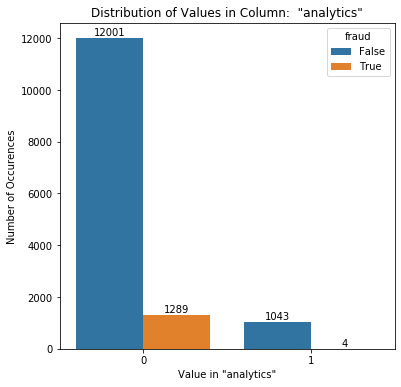

The percentage of fraud for entries with analytics equal to 0 is 9.7%
The percentage of fraud for entries with analytics equal to 1 is 0.38%


In [18]:
compare_fraud_rate('analytics')

* ##### logo

In [19]:
data.logo.value_counts()

1    12073
0     2264
Name: logo, dtype: int64

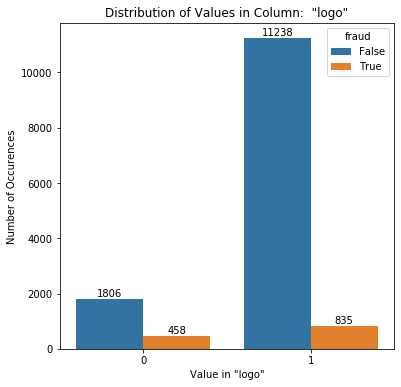

The percentage of fraud for entries with logo equal to 0 is 20.23%
The percentage of fraud for entries with logo equal to 1 is 6.92%


In [20]:
compare_fraud_rate('logo')

* ##### map

In [21]:
data.map.value_counts()

1    12103
0     2234
Name: map, dtype: int64

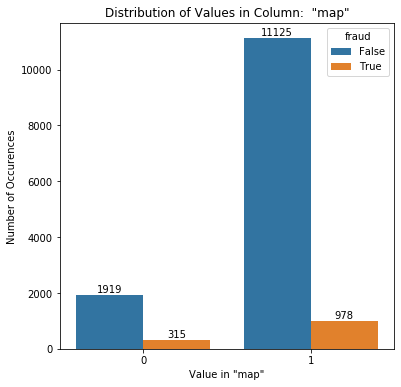

The percentage of fraud for entries with map equal to 0 is 14.1%
The percentage of fraud for entries with map equal to 1 is 8.08%


In [22]:
compare_fraud_rate('map')

* ##### member_type

In [23]:
data.member_type.value_counts()

3      7520
1      3738
4      3017
5        59
103       2
2         1
Name: member_type, dtype: int64

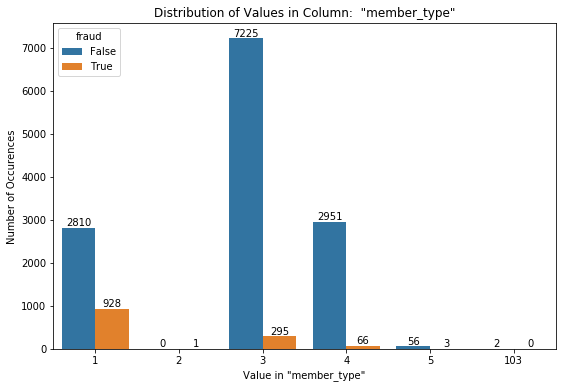

The percentage of fraud for entries with member_type equal to 1 is 24.83%
The percentage of fraud for entries with member_type equal to 2 is 100%
The percentage of fraud for entries with member_type equal to 3 is 3.92%
The percentage of fraud for entries with member_type equal to 4 is 2.19%
The percentage of fraud for entries with member_type equal to 5 is 5.08%
The percentage of fraud for entries with member_type equal to 103 is 0%


In [24]:
compare_fraud_rate('member_type')

* ##### channels

In [25]:
data.channels.value_counts()

8     3364
0     2941
5     2459
11    2312
6     1736
4      556
12     470
10     237
13     232
9       20
7       10
Name: channels, dtype: int64

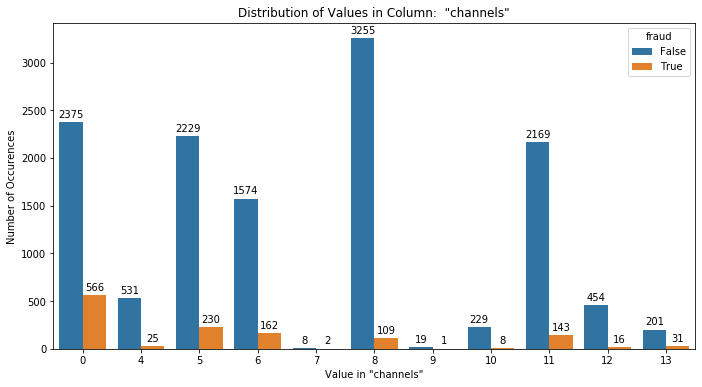

The percentage of fraud for entries with channels equal to 0 is 19.25%
The percentage of fraud for entries with channels equal to 4 is 4.5%
The percentage of fraud for entries with channels equal to 5 is 9.35%
The percentage of fraud for entries with channels equal to 6 is 9.33%
The percentage of fraud for entries with channels equal to 7 is 20.0%
The percentage of fraud for entries with channels equal to 8 is 3.24%
The percentage of fraud for entries with channels equal to 9 is 5.0%
The percentage of fraud for entries with channels equal to 10 is 3.38%
The percentage of fraud for entries with channels equal to 11 is 6.19%
The percentage of fraud for entries with channels equal to 12 is 3.4%
The percentage of fraud for entries with channels equal to 13 is 13.36%


In [26]:
compare_fraud_rate('channels')

In [27]:
int_cats = ['fb_published', 'analytics', 'logo', 'map', 'member_type', 'channels']

In [28]:
cat_cols = cat_cols + int_cats

## 2.2 Float Columns

In [29]:
report(flt_col).T

,name,Number of Unique Values,Number of NaN,Max,Min,Mode,Frequency of Mode
0,delivery_method,3,16,3,0,0,59.43%
1,date_published,14181,99,1.38161e+09,0,0,0.39%
2,header,2,5409,1,0,0,49.69%
3,org_facebook,81,59,91,0,0,56.48%
4,org_twitter,23,59,34,0,0,63.62%
5,sale_duration,375,155,980,-1094,0,2.51%
6,venue_latitude,10525,1076,64.844,-45.0452,0,3.19%
7,venue_longitude,10514,1076,176.169,-159.39,0,3.19%


* org_facebook, org_twitter, sale_duration : continuous
* header, delivery_method : categorical

### A - Continuous

In [30]:
#
data.fillna({'org_facebook':0, 'org_twitter':0, 'sale_duration':0}, inplace=True)

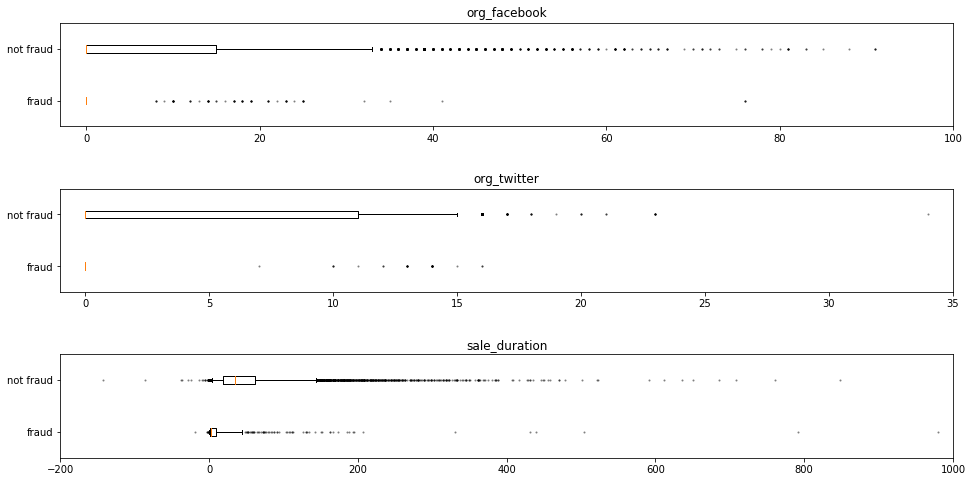

In [31]:
float_cont = ['org_facebook', 'org_twitter', 'sale_duration']
xranges = [[-3,100],[-1,35],[-200,1000]]
fig, axs = plt.subplots(3,1, figsize =(16,8))
for idx, ax in enumerate(axs.flatten()):    
    ax.boxplot([data[data.fraud == True][float_cont[idx]], data[data.fraud == False][float_cont[idx]]], 
               labels=['fraud', 'not fraud'], flierprops=dict(marker='.', markersize=2, alpha=.5), vert=False,
               whis=[5, 95])
    ax.set_title(float_cont[idx])
    ax.set_xlim(xranges[idx])
plt.subplots_adjust(hspace = 0.6)

### B - Categorical

#### Take a closer look if the column appears categorical 
Look for columns with small numbers of unique values

* #### Column :  "delivery_method"

In [32]:
data.delivery_method.value_counts()

0.0    8520
1.0    5554
3.0     247
Name: delivery_method, dtype: int64

In [33]:
data.delivery_method.fillna(2, inplace=True)
data.delivery_method = data.delivery_method.astype(int)
data.delivery_method.value_counts()

0    8520
1    5554
3     247
2      16
Name: delivery_method, dtype: int64

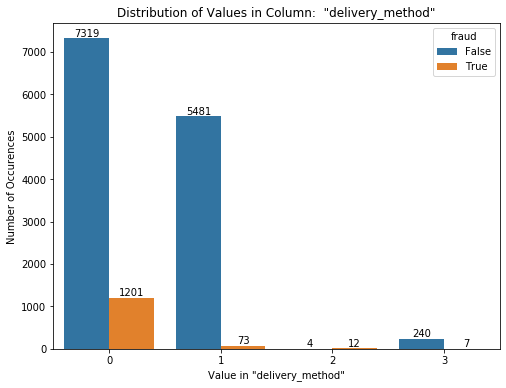

The percentage of fraud for entries with delivery_method equal to 0 is 14.1%
The percentage of fraud for entries with delivery_method equal to 1 is 1.31%
The percentage of fraud for entries with delivery_method equal to 2 is 75.0%
The percentage of fraud for entries with delivery_method equal to 3 is 2.83%


In [34]:
compare_fraud_rate('delivery_method')

* #### Column :  "header"

In [35]:
data.header.value_counts()

0.0    7124
1.0    1804
Name: header, dtype: int64

In [36]:
data.header.fillna(2, inplace=True)
data.header = data.header.astype(int)
data.header.value_counts()

0    7124
2    5409
1    1804
Name: header, dtype: int64

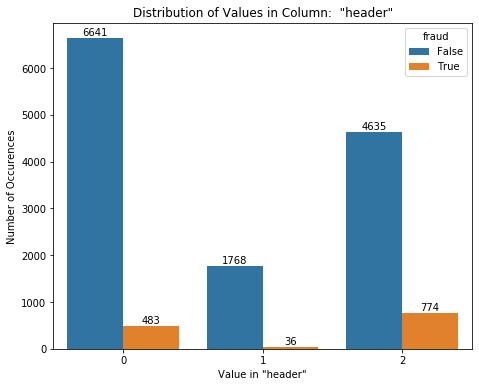

The percentage of fraud for entries with header equal to 0 is 6.78%
The percentage of fraud for entries with header equal to 1 is 2.0%
The percentage of fraud for entries with header equal to 2 is 14.31%


In [37]:
compare_fraud_rate('header')

In [38]:
cat_cols = cat_cols + ['delivery_method', 'header']

## 2.3 String Columns
Note: We can limit view to first three columns because all values for Max, Min, Mode, & Freq. of Mode are 'None' 

In [39]:
report(str_col).iloc[:3,:].T

,name,Number of Unique Values,Number of NaN
0,country,70,399
1,currency,7,0
2,description,13094,829
3,email_domain,5772,0
4,listed,2,0
5,name,13938,86
6,org_desc,5844,6165
7,org_name,9500,1462
8,payee_name,2480,11160
9,payout_method,2,493


* #### listed

In [40]:
data.listed.value_counts()

y    12291
n     2046
Name: listed, dtype: int64

In [41]:
data.listed.replace({'y':1, 'n':0}, inplace=True)

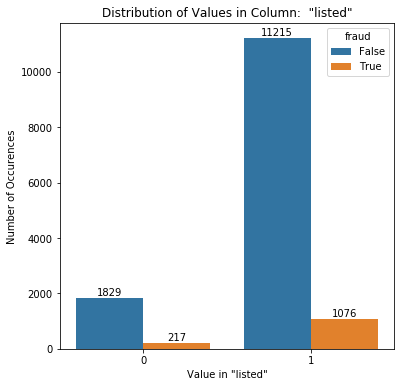

The percentage of fraud for entries with listed equal to 0 is 10.61%
The percentage of fraud for entries with listed equal to 1 is 8.75%


In [42]:
compare_fraud_rate('listed')

* #### payout_method

In [43]:
data.payout_method.value_counts()

ACH      10666
CHECK     3178
Name: payout_method, dtype: int64

In [44]:
data.payout_method.fillna("", inplace=True)
data.payout_method.replace({"ACH": 0, "CHECK": 1, "": 2}, inplace=True)

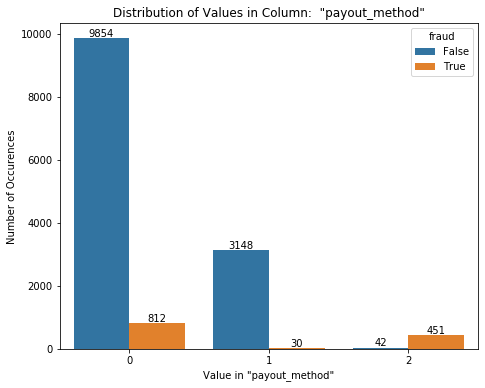

The percentage of fraud for entries with payout_method equal to 0 is 7.61%
The percentage of fraud for entries with payout_method equal to 1 is 0.94%
The percentage of fraud for entries with payout_method equal to 2 is 91.48%


In [45]:
compare_fraud_rate('payout_method')

* #### currency

In [46]:
data.currency.value_counts()

USD    9696
GBP    2222
CAD    1322
AUD     779
EUR     262
NZD      55
MXN       1
Name: currency, dtype: int64

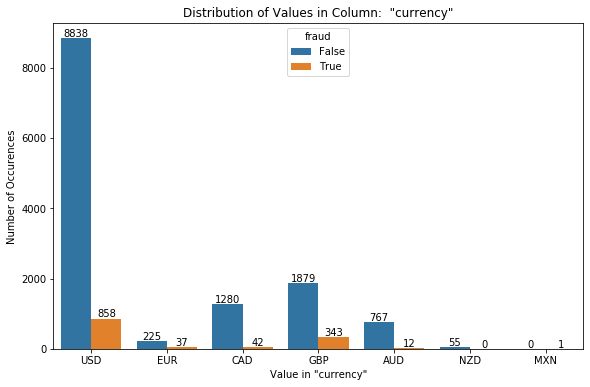

The percentage of fraud for entries with currency equal to AUD is 1.54%
The percentage of fraud for entries with currency equal to CAD is 3.18%
The percentage of fraud for entries with currency equal to EUR is 14.12%
The percentage of fraud for entries with currency equal to GBP is 15.44%
The percentage of fraud for entries with currency equal to MXN is 100%
The percentage of fraud for entries with currency equal to NZD is 0%
The percentage of fraud for entries with currency equal to USD is 8.85%


In [47]:
compare_fraud_rate('currency')

* #### country

In [48]:
country_dict = {k:v for v, k in enumerate(list(data.country.unique()))}
data.country.replace(country_dict, inplace=True)

In [49]:
data.country.value_counts()[:10]

0     9234
4     2083
3     1262
6      742
5      399
12      73
1       48
14      47
9       43
2       40
Name: country, dtype: int64

### Review of the categorical features you identified 

In [50]:
cat_cols = cat_cols + ['listed', 'payout_method', 'currency', 'country']

In [51]:
report(cat_cols).T

,name,Number of Unique Values,Number of NaN,Max,Min,Mode,Frequency of Mode
0,fb_published,2,0,1,0,0,87.26%
1,analytics,2,0,1,0,0,92.7%
2,logo,2,0,1,0,1,84.21%
3,map,2,0,1,0,1,84.42%
4,member_type,6,0,103,1,3,52.45%
5,channels,11,0,13,0,8,23.46%
6,delivery_method,4,0,3,0,0,59.43%
7,header,3,0,2,0,0,49.69%
8,listed,2,0,1,0,1,85.73%
9,payout_method,3,0,2,0,0,74.39%
